In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

print(torchvision.__version__)
torch.backends.mps.is_available()

0.13.1


True

In [2]:
dataroot = "data"

IMAGE_SIZE = config['default'].getint('image_size')
CHANNELS = config['default'].getint('channels')
BATCH_SIZE = config['default'].getint('batch_size')
SEED = config['default'].getint('seed')

EPOCHS = config['training'].getint('epochs')
START_LR = config['training'].getfloat('start_lr')
MAX_LR = config['training'].getfloat('max_lr')
STEPS_PER_EPOCH = config['training'].getint('steps_per_epoch')
ANNEAL_STRATEGY = config['training']['strategy']

GEN_FEATURE_MAPS = config['generator'].getint('feature_maps')
Z_LATENT = config['generator'].getint('z_latent')
DIS_FEATURE_MAPS = config['discriminator'].getint('feature_maps')

N_GPUS = 1

"""
wandb.config.update({'epochs': EPOCHS, 
                     'image_size': IMAGE_SIZE, 
                     'batch_size': BATCH_SIZE,
                     'start_lr': START_LR,
                     'max_lr': MAX_LR, 
                     'strategy': ANNEAL_STRATEGY})
"""

"\nwandb.config.update({'epochs': EPOCHS, \n                     'image_size': IMAGE_SIZE, \n                     'batch_size': BATCH_SIZE,\n                     'start_lr': START_LR,\n                     'max_lr': MAX_LR, \n                     'strategy': ANNEAL_STRATEGY})\n"

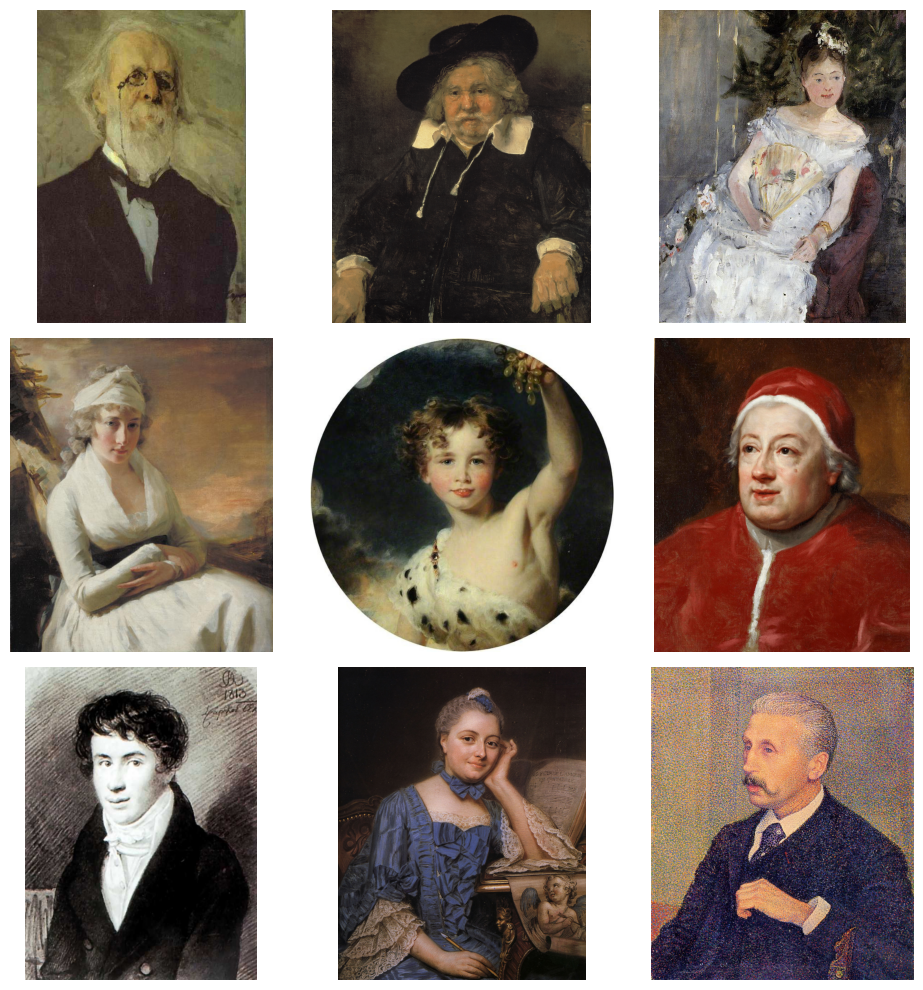

In [3]:
import os
import random
from PIL import Image

paths = os.listdir('data/portraits')

plt.figure(figsize=(10, 10))

for i in range(9):
    path = 'data/portraits/' + random.choice(paths)
    img = np.asarray(Image.open(path))

    # show image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()

Using device mps


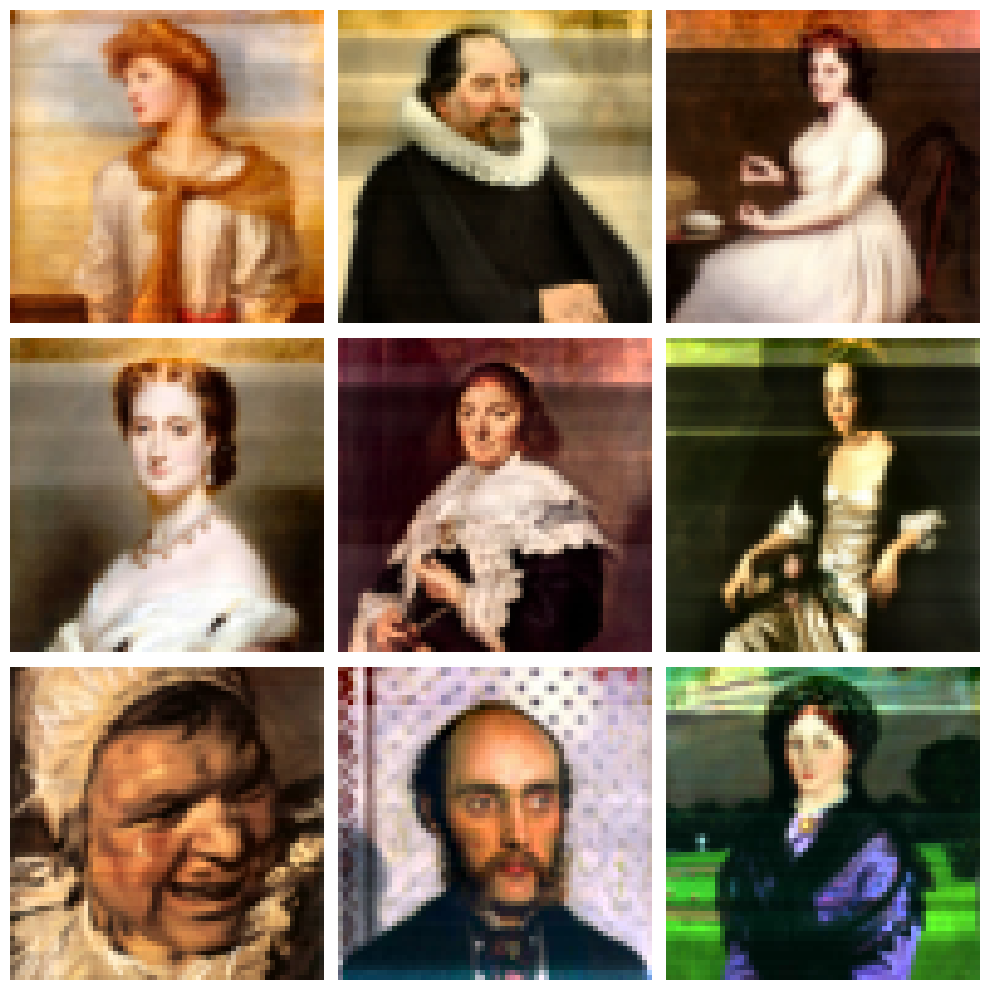

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

# Decide which device we want to run on
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device {device}')

i = 0
plt.figure(figsize=(10, 10))

for inputs, targets in dataloader:
    for img in inputs:
        image = img.numpy()
        # transpose image to fit plt input
        image = image.transpose((1, 2, 0))
        # normalise image
        data_min = np.min(image, axis=(1,2), keepdims=True)
        data_max = np.max(image, axis=(1,2), keepdims=True)
        scaled_data = (image - data_min) / (data_max - data_min)
        # show image
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(scaled_data)
        plt.axis('off')

        i += 1
        if i == 9:
            break

    break

plt.tight_layout()

In [5]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d(Z_LATENT, GEN_FEATURE_MAPS * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(GEN_FEATURE_MAPS * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(GEN_FEATURE_MAPS * 8, GEN_FEATURE_MAPS * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FEATURE_MAPS * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(GEN_FEATURE_MAPS * 4, GEN_FEATURE_MAPS * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FEATURE_MAPS * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(GEN_FEATURE_MAPS * 2, GEN_FEATURE_MAPS, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FEATURE_MAPS),
            nn.ReLU(True),

            nn.ConvTranspose2d(GEN_FEATURE_MAPS, CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(CHANNELS, DIS_FEATURE_MAPS, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIS_FEATURE_MAPS, DIS_FEATURE_MAPS * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DIS_FEATURE_MAPS * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIS_FEATURE_MAPS * 2, DIS_FEATURE_MAPS * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DIS_FEATURE_MAPS * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIS_FEATURE_MAPS * 4, DIS_FEATURE_MAPS * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DIS_FEATURE_MAPS * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIS_FEATURE_MAPS * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [6]:
netG = Generator(N_GPUS).to(device)

if (device.type == 'cuda') and (N_GPUS > 1):
    netG = nn.DataParallel(netG, list(range(N_GPUS)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
netD = Discriminator(N_GPUS).to(device)

if (device.type == 'cuda') and (N_GPUS > 1):
    netD = nn.DataParallel(netD, list(range(N_GPUS)))

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [8]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, Z_LATENT, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=START_LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=START_LR, betas=(0.5, 0.999))

In [10]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(EPOCHS):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_LATENT, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/33]	Loss_D: 1.5822	Loss_G: 4.1606	D(x): 0.4480	D(G(z)): 0.4316 / 0.0206
[1/5][0/33]	Loss_D: 0.3021	Loss_G: 21.3270	D(x): 0.8480	D(G(z)): 0.0000 / 0.0000
[2/5][0/33]	Loss_D: 0.0029	Loss_G: 27.5087	D(x): 0.9972	D(G(z)): 0.0000 / 0.0000
[3/5][0/33]	Loss_D: 0.0027	Loss_G: 36.2255	D(x): 0.9975	D(G(z)): 0.0000 / 0.0000
[4/5][0/33]	Loss_D: 0.0039	Loss_G: 35.4965	D(x): 0.9963	D(G(z)): 0.0000 / 0.0000


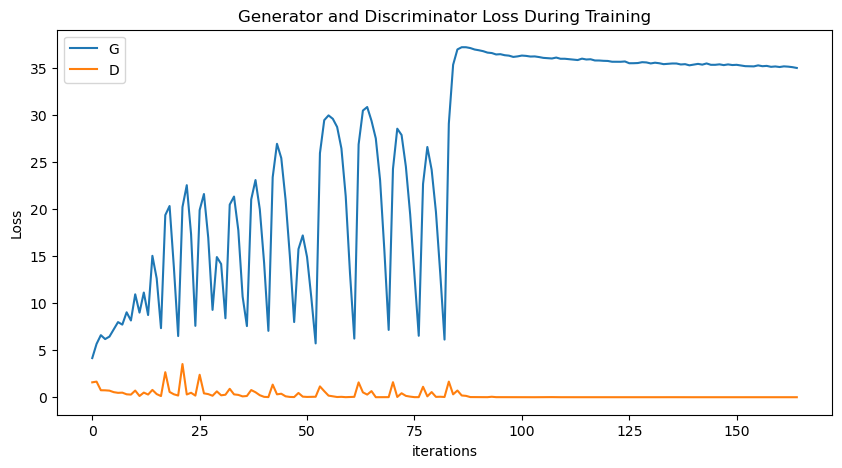

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

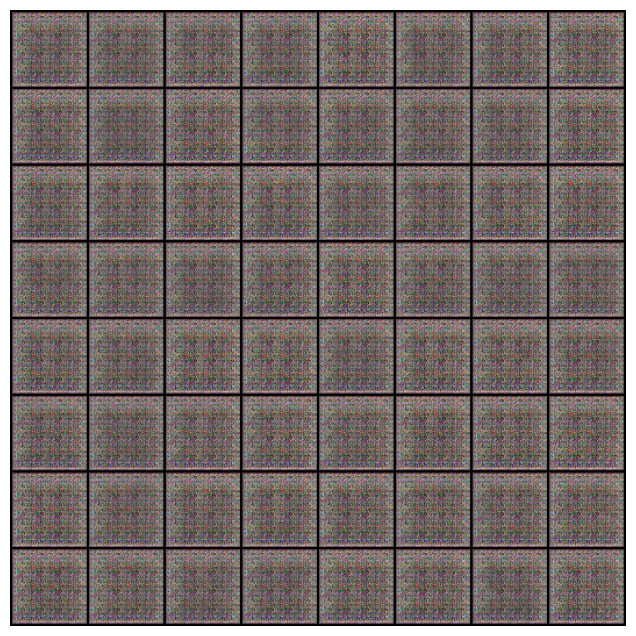

In [13]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())